<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="https://raw.githubusercontent.com/jupyter/nature-demo/master/images/jupyter-logo.png" width="150px" style="display: inline-block; margin-top: 65px;">
<a href="http://linkedin.com/in/corypruce/"><img src="http://blackbaseball.com/wp-content/uploads/2012/03/linkedin-logo.png" width="150px" class="pull-right" style="display: inline-block; margin: 0px;"></a>
</div>

# Cory Pruce
## Zika Virus Posts Early Data Analysis <br/>

<div class="alert alert-info" role="alert" style="margin: 10px">
<p>**Prelude**</p>

<p>The following is a toy project that investigates a small dataset of Zika media posts via a few simple tasks and some exploratory analysis. In this notebook, green boxes represent tasks, where as blue boxes represent my personal input. </p>
</div>

### Geographic Location Clustering using K-means
<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-success" role="alert" style="margin: 10px">
We have developed an algorithm that extracts geographic locations from text and we want to visualize the locations on a map! Attached is a tab separated file (zika_latitude_longitude.tsv) with the latitude, longitude, title, date, and topic of events associated with a month's worth of Zika news. <br/> <br/>

Given this data, the following should be performed:

<p>- **Plot the locations on a map.**</p>
</div>
</div>

finished reading: (119, 5)
finished dropping duplicates: (119, 5)
err:  40.71427, -74.00596999999999  coordinate is still added to list


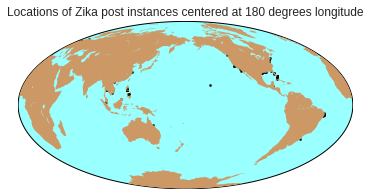

In [13]:
# using as docker environment:
# https://github.com/Kaggle/docker-python

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns

import plotly
import plotly.plotly as py
from geopy import geocoders
from geopy.geocoders import Nominatim

filename = './zika_latitude_longitude.tsv'

df = pd.read_csv(filename, sep='\t')
df.head()
print("finished reading:", df.shape)
df.drop_duplicates()
print("finished dropping duplicates:", df.shape)

# for later use in plotting
df_lng_mat = df['longitude'].as_matrix()
df_lat_mat = df['latitude'].as_matrix()

def do_geocode(address):
    """
    If exception (likely GeocoderTimedOut), log and don't return the address.
    Coordinate will be retained but with no location data.
    """
    try:
        return geolocator.reverse(address).address
    except Exception as e: 
        print("err: ", address, ' coordinate is still added to list') # discovery of heterogenous data set here
        return "" 

geolocator = Nominatim()
np_df = df.as_matrix()
locations, coordinates = [], []
for row in np_df:
    coordinate = ''.join([str(row[0]), ", ", str(row[1])])
    location = do_geocode(coordinate) 
    locations.append(location)
    coordinates.append(coordinate)
        
        
# ref: http://matplotlib.org/basemap/users/figures/plotargo.py
cities = []

import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib.request, os

# draw map with markers for float locations
m = Basemap(projection='hammer',lon_0=180)
x, y = m(df_lng_mat, df_lat_mat) 
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,5,marker='o',color='k')
plt.title('Locations of Zika post instances centered at 180 degrees longitude',fontsize=12)
plt.show()

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**To start with, the visualizations could be tailored to better represent the data, communicate the underlying information, and be more ready to handle the k-means clusters.**
</div>
</div>

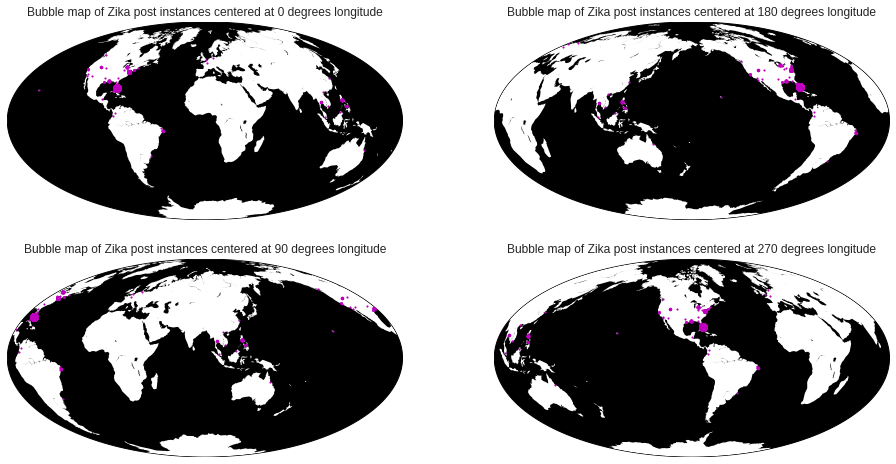

In [15]:
# quick way to count the number of uniq coordinates and designate group count.
# Counter is likely better as it might be more lean, would use one key, and minimizes redundancy
# ref: http://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column#22391554
df['freq'] = df.groupby(['latitude', 'longitude'])['latitude'].transform('count')
freq_groupby = df.groupby(['freq'])

# Given the small and stable dataset, creating a column of strings seems like a good idea for lookup
# ref: http://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python
df["geo_coord"] = df["latitude"].map(str).map(lambda x: x+', ') + df["longitude"].map(str)

from collections import Counter
coord_counter = Counter(coordinates)

# using as max/min longitude ref: 
# ref: http://stackoverflow.com/questions/15965166/what-is-the-maximum-length-of-latitude-and-longitude
# using as subplots ref:
# ref: http://basemaptutorial.readthedocs.io/en/latest/subplots.html#using-subplot2grid

fig = plt.figure(figsize=(16, 8))

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1))

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    meridian = 90*i
    map_ax = Basemap(projection='hammer',lon_0=meridian, ax=ax)
    ax.set_title('Bubble map of Zika post instances centered at %s degrees longitude' % (str(meridian)),fontsize=12)
    
    map_ax.drawmapboundary(fill_color='black')
    map_ax.fillcontinents(color='white',lake_color='black',zorder=0)
    
    # scale so that the smallest instances (ie, 1) are visible
    scale = 3
    for i, (name, group) in enumerate(freq_groupby):
        x, y = map_ax(group['longitude'].as_matrix(), group['latitude'].as_matrix())
        map_ax.scatter(x,y,name*scale,marker='o',color='m')
    

plt.show()

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**Looks like the *US East Coast* and *SE Asia* likely either got swamped with Zika instances, or there is a sampling bias in our dataset. Given the nature of the data, this is probably most efficiently resolved with outside information, ie. other datasets. <br/> <br/>

Regarding the visualizations, the black-white-magenta contrast seems to do well in showing the areas of bubbles. The bubble areas represent the number of instances with those coordinates. Though these figures show a decent amount of information, some improvements can be made. The scale of these should be made to penalize the larger numbers, since they get magnified. Localized areas and hover labels can be targetted for the exploratory portion. <br/> <br/>

That all said, it is time for k-means, which should also help with the visualization.**
</div>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-success" role="alert" style="margin: 10px">
- **Determine the geographic location hotspots making use of the k-means clustering algorithm. While there are better clustering algorithms, we are interested in how you diagnose the performance of an algorithm and what choices you make in how to apply that algorithm.** <br/>
- In your final write up, describe how well the clustering algorithm worked. How did you select K? Make sure to take me through your journey on how you decided on a final clustering.
</div>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**For kmeans, using the coordinates as the features in our distance function makes the most intuitive sense. The latitude/longitude combination is likely the most relevant piece for visual clustering, due to the geographic context (later analysis identifies other pieces of information, ie. title and date, that could signal visual cues).<br/> <br/>

Since sklearn and scipy have great API and community support, these libraries were an easy go-to for an initial approach. I also found a notebook that proved to be a great start (docker/python). Something to investigate is other measures of goodnes-of-fit that are not the average sum of squares within clusters. As mentioned in the exploratory section, perhaps additional information can be added to the distance metric besides just the *coordinate - centroid coordinate*. An idea is to use dates/times in order to identify flows. However, this could be subject to a lot of noise since the accuracy of the dates/times, as well as the correlation between flows and post times, are subject. <br/> <br/>

Using the referenced notebook below, clusters were created for *K* in the range 1-10. Afterwards, the "within cluster sum-of-squares" distance was taken for each set of kmeans clusters. The average sum of squares of distances from the center of the centroids is reduced the most for *K* in range 1-2. Having *K* = 3 seems like an interesting representation since it essentially splits the globe into 3 distinct regions.**
</div>
</div>

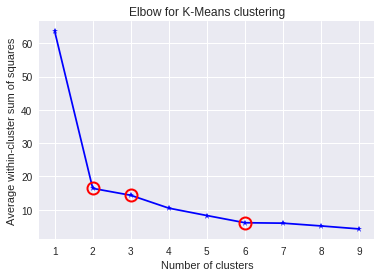

In [16]:
# using as kmeans ref:
# http://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/D3.%20K-Means%20Clustering%20Analysis.ipynb

import sklearn
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

# as will be seen with the elbow graph, the goodness of fit's improvement rate 
# significantly plateaus towards the end of the graph, with not much more to gain 
K = range(1,10)
# extract coordinates and convert to float64
np_coords = np.asarray(list(map(lambda x: list(map(
    lambda y: np.float64(y), x.split(', '))),coordinates)))
# scipy.cluster.vq.kmeans
KM = [kmeans(np_coords,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

# use euclidean distance in the cartesian space
D_k = [cdist(np_coords, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/np_coords.shape[0] for d in dist] 


# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
kIdx = 1
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
kIdx = 2
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
kIdx = 5
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**While there are a few good candidates (some more so than others), it is dangerous to rely on the resulting numbers too much. No clustering is right for every problem. Perhaps we'd like to plot a potential global, continental, national, or even state spread model. All of these scenarios would likely require different numbers of clusters. <br/>
<br/>

Trying out 2 and 3 seem reasonable. *K* = 6 also seems to be at the front of a plateau. **
</div>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-success" role="alert" style="margin: 10px">
- **Plot the geographic location hotspots on a map.**
</div>
</div>

(119, 2)


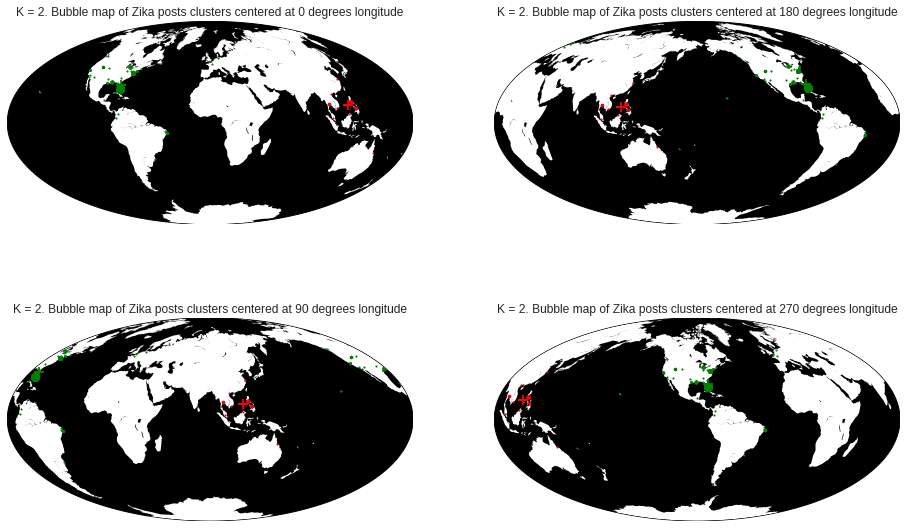

In [17]:
from sklearn.cluster import KMeans
k = 2
km = KMeans(k, init='k-means++') # initialize
print(np_coords.shape)
km.fit(np_coords)
cluster_pred = km.predict(np_coords) # classify into three clusters
cluster_centers = km.cluster_centers_

colors = ['g', 'r', 'b', 'y', 'c', 'm']

def get_lng(clist):
    """
    Extract list of longitude coordinates
    """
    return list(map(lambda p: p[1], clist))

def get_lat(clist):
    """
    Extract list of latitude coordinates
    """
    return list(map(lambda p: p[0], clist))
    
clusters = {}
for i in range(0, k):
    clusters[i] = []
    for x,y in zip(cluster_pred, np_coords):
        if x == i:
            clusters[i].append(y)
   
# multi-color inspiration from: 
# http://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib

# plot coordinates in clusters
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1))

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    meridian = 90*i
    map_ax = Basemap(projection='hammer',lon_0=meridian, ax=ax)
    map_ax.drawmapboundary(fill_color='black')
    map_ax.fillcontinents(color='white',lake_color='black',zorder=0)
    
    # loop through clusters
    for i in range(0, k):
         
        # freq group dictionary idea from:
        # http://stackoverflow.com/questions/14734533/how-to-access-pandas-groupby-dataframe-by-key#17302673
        freq_groups = dict(list(freq_groupby))
        
        # loop through frequency groups in order to plot correct bubble sizes
        for j, freq_group in enumerate(freq_groups):
            zipped = list(map(lambda x: np.array(x), zip(freq_groups[freq_group]['latitude'].as_matrix(), 
                                                         freq_groups[freq_group]['longitude'].as_matrix())))
            
            cluster_freq_group = [x for x in zipped if str(x) in list(map(str, clusters[i]))]
            lngs = get_lng(cluster_freq_group)
            lats = get_lat(cluster_freq_group)
            x, y = map_ax(lngs, lats)
            
            # scale so that the smallest instances (ie, 1) are visible
            scale = 3 # 3/np.exp(freq_group)
            
            map_ax.scatter(x,y,freq_group*scale,marker='o',color=colors[i])
        
        # plot the hot spots
        cc = cluster_centers[i]
        x, y = map_ax([cc[1]], [cc[0]])
        map_ax.scatter(x, y, 84, marker='+', color=colors[i])
        
    ax.set_title('K = %d. Bubble map of Zika posts clusters centered at %d degrees longitude' % (k, meridian),fontsize=12)

plt.show()

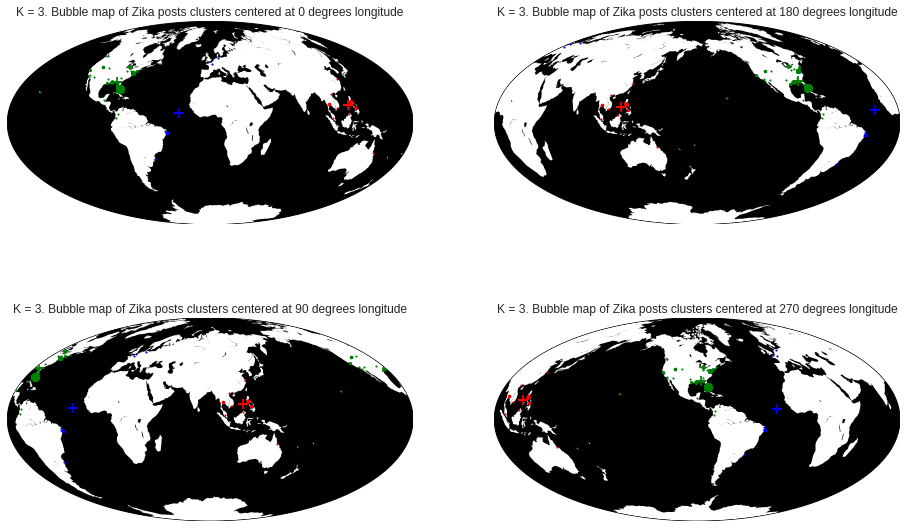

In [18]:
k = 3
km = KMeans(k, init='k-means++') # initialize
km.fit(np_coords)
cluster_pred = km.predict(np_coords) # classify into three clusters
cluster_centers = km.cluster_centers_

clusters = {}
for i in range(0, k):
    clusters[i] = []
    for x,y in zip(cluster_pred, np_coords):
        if x == i:
            clusters[i].append(y)
   
# multi-color inspiration from: 
# http://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib

# plot coordinates in clusters
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1))

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    meridian = 90*i
    map_ax = Basemap(projection='hammer',lon_0=meridian, ax=ax)
    map_ax.drawmapboundary(fill_color='black')
    map_ax.fillcontinents(color='white',lake_color='black',zorder=0)
    
    # loop through clusters
    for i in range(0, k):
        
        # scale so that the smallest instances (ie, 1) are visible
        scale = 3
        
        # freq group dictionary idea from:
        # http://stackoverflow.com/questions/14734533/how-to-access-pandas-groupby-dataframe-by-key#17302673
        freq_groups = dict(list(freq_groupby))
        
        # loop through frequency groups in order to plot correct bubble sizes
        for j, freq_group in enumerate(freq_groups):
            zipped = list(map(lambda x: np.array(x), zip(freq_groups[freq_group]['latitude'].as_matrix(), 
                                                         freq_groups[freq_group]['longitude'].as_matrix())))
            
            cluster_freq_group = [x for x in zipped if str(x) in list(map(str, clusters[i]))]
            lngs = get_lng(cluster_freq_group)
            lats = get_lat(cluster_freq_group)
            x, y = map_ax(lngs, lats)
            map_ax.scatter(x,y,freq_group*scale,marker='o',color=colors[i])
        
        # plot the hot spots
        cc = cluster_centers[i]
        x, y = map_ax([cc[1]], [cc[0]])
        map_ax.scatter(x, y, 84, marker='+', color=colors[i])
        
    ax.set_title('K = %d. Bubble map of Zika posts clusters centered at %d degrees longitude' % (k, meridian),fontsize=12)

plt.show()

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
** *K* = 2 and *K* = 3 actually did pretty well. Although *K* = 3 seems to give some good insight, the real insight is dependent on the problem at hand. <br/> <br/>

I plotted the cluster centers with a '+' sign. Initially, I plotted a large circle, but I chose to differentiate the centroid center even more to stay consistent with the data. One downside of using the '+' sign is that the sign can get engulfed by circles, if desired to be the same color as its cluster. There is likely a way to highlight these markers, though more interesting tasks should be investigated. I tried edge lines with no quick success. Additionally, I should look into scaling while penalizing larger numbers, as 3\*21 will have a larger impact than 3\*21. Another thing to look into on this front is if places being *freq_group* plotted is magnifying the points even more. <br/> <br/>

There is, on average, still some drop off until about *K* = 6. Additionally, this visually makes sense, as regions of a hemisphere may not be the closest in terms of context. For example, flights from China and South-East Asia to the U.S. are common and flights from there complicate the scenario even more. Therefore, a grouping of the Europe and Brazil might provide incorrect assumptions. So, a more local view could give better insight.**
</div>
</div>

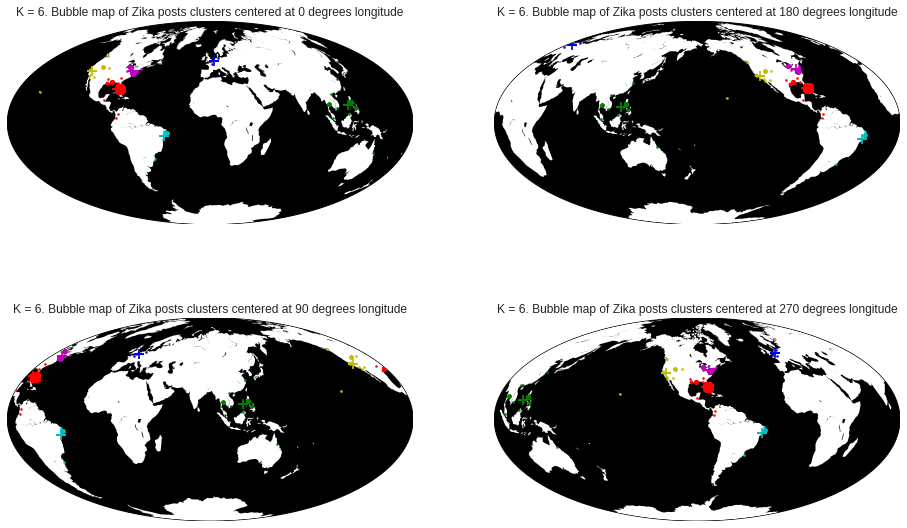

In [19]:
k = 6
km = KMeans(k, init='k-means++') # initialize
km.fit(np_coords)
cluster_pred = km.predict(np_coords) # classify into three clusters
cluster_centers = km.cluster_centers_

clusters = {}
for i in range(0, k):
    clusters[i] = []
    for x,y in zip(cluster_pred, np_coords):
        if x == i:
            clusters[i].append(y)

# multi-color inspiration from: 
# http://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib

# plot coordinates in clusters
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1))
ax4 = plt.subplot2grid((2,2), (1,1))

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    meridian = 90*i
    map_ax = Basemap(projection='hammer',lon_0=meridian, ax=ax)
    map_ax.drawmapboundary(fill_color='black')
    map_ax.fillcontinents(color='white',lake_color='black',zorder=0)
    
    for i in range(0, k):
        
        scale = 5
        
        # freq group dictionary idea from:
        # http://stackoverflow.com/questions/14734533/how-to-access-pandas-groupby-dataframe-by-key#17302673
        freq_groups = dict(list(freq_groupby))
        for j, freq_group in enumerate(freq_groups):
            
            
            
            zipped = list(map(lambda x: np.array(x), zip(freq_groups[freq_group]['latitude'].as_matrix(), 
                                                         freq_groups[freq_group]['longitude'].as_matrix())))
            
            cluster_freq_group = [x for x in zipped if str(x) in list(map(str, clusters[i]))]
            lngs = get_lng(cluster_freq_group)
            lats = get_lat(cluster_freq_group)
            x, y = map_ax(lngs, lats)
            # though using (j+1) instead of freq_group looks better, it is not as true to the data
            map_ax.scatter(x,y,scale*freq_group,marker='o',color=colors[i], picker=True)
            
        
        cc = cluster_centers[i]
        x, y = map_ax([cc[1]], [cc[0]])
        map_ax.scatter(x, y, 84, marker='+', color=colors[i], edgecolors='k')
     
    ax.set_title('K = %d. Bubble map of Zika posts clusters centered at %d degrees longitude' % (k, meridian),fontsize=12)

plt.show()

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**The *K* = 6 try seemed to classify the groups pretty well. Besides attributing Brazil and Europe to their respective groups, the number of clusters also seems to have helped Brazil's cluster center get rectified and allowed for the US to be split into more distinct regions.<br/> <br/>

I looked into but chose not to toggle the scipy and sklearn kmeans algorithms since the extra paramters seemed not to give any apparent gain and the clustering algorithm represented more-or-less what I'd like to show. An area of interest seems to be the region near Ecuador. With *K* = 6, this seems to have been grouped together with the US Southeast. This seems to be inaccurate, though the clustering with Brazil doesn't seem to be too close either. Maybe these points are their own cluster, or are leakage of information for a larger, lower-reported Zika problem.**
</div>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-success" role="alert" style="margin: 10px">
- **Do something cool!  For this part find something cool to show off.  <br/> <br/>

Be creative, no right answer here, we are just looking for you to show off your skills.<br/> <br/>

Note that, algorithm development should be done in python but visualization can be done in any framework you feel comfortable with except Google Maps.**
</div>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**I mentioned looking into some localized maps before. Upon looking into subplots with mpl's Basemap, I found a really cool zoom grid that I thought was perfect for giving multiple perspectives (http://basemaptutorial.readthedocs.io/en/latest/subplots.html#using-subplot2grid).**
</div>
</div>

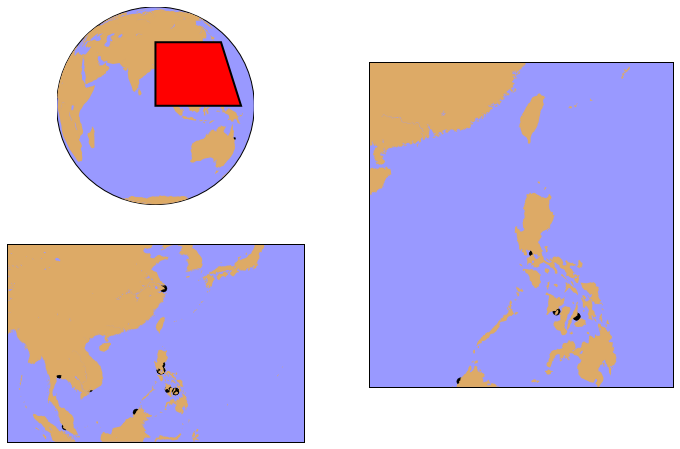

In [20]:
from matplotlib.path import Path
import matplotlib.patches as patches

fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)

map1 = Basemap(projection='ortho', lon_0 = 90, lat_0 = 0, ax=ax1)

map1.drawmapboundary(fill_color='#9999FF')
map1.fillcontinents(color='#ddaa66',lake_color='#9999FF')
x, y = map1(df_lng_mat, df_lat_mat)
map1.scatter(x,y,5,marker='o',color='k')


map2 = Basemap(projection='cyl', llcrnrlon=90,llcrnrlat=0,urcrnrlon=150.,urcrnrlat=40., resolution='i', ax=ax2)

map2.drawmapboundary(fill_color='#9999FF')
map2.fillcontinents(color='#ddaa66',lake_color='#9999FF')
x, y = map2(df_lng_mat, df_lat_mat)
map2.scatter(x,y,50,marker='o',color='k')


map3 = Basemap(llcrnrlon= 110., llcrnrlat=5.5, urcrnrlon= 131.530762,urcrnrlat=26.955928,
               resolution='i', projection='tmerc', lon_0 = 120.0, lat_0 = 10., ax=ax3) #
                
map3.drawmapboundary(fill_color='#9999FF')
map3.fillcontinents(color='#ddaa66',lake_color='#9999FF')
x, y = map3(df_lng_mat, df_lat_mat)
map3.scatter(x,y,55,marker='o',color='k')


#Drawing the zoom rectangles:

lbx1, lby1 = map1(*map2(map2.xmin, map2.ymin, inverse= True))
ltx1, lty1 = map1(*map2(map2.xmin, map2.ymax, inverse= True))
rtx1, rty1 = map1(*map2(map2.xmax, map2.ymax, inverse= True))
rbx1, rby1 = map1(*map2(map2.xmax, map2.ymin, inverse= True))

verts1 = [
    (lbx1, lby1), # left, bottom
    (ltx1, lty1), # left, top
    (rtx1, rty1), # right, top
    (rbx1, rby1), # right, bottom
    (lbx1, lby1), # ignored
    ]

codes2 = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts1, codes2)
patch = patches.PathPatch(path, facecolor='r', lw=2)
ax1.add_patch(patch)


plt.show()

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**Additionally, I thought it would be a cool idea to look into the number of instances by country.**
</div>
</div>

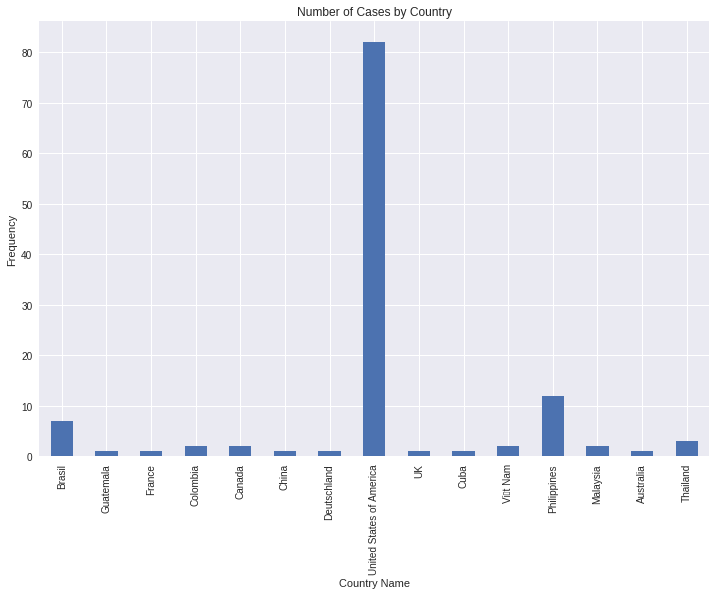

In [8]:
uniq_coords = set(coordinates)

# see number of entries by country
countries = []
cases = []
for coord in uniq_coords:
    country = do_geocode(coord).split(', ')[-1] # look up country
    num_cases = coord_counter[coord] # look up number of coordinate dups
    countries.append(country)
    cases.append(num_cases)
    
# Convert to printable, English names
country_names_map = {
    'ประเทศไทย': 'Thailand',
    '中国': 'China'
}
countries = list(map(lambda x: country_names_map[x] if x in country_names_map else x, countries))

# Aggregate country cases
uniq_countries = list(set(countries))
sum_cases = np.zeros(len(uniq_countries))
for cntry, cntry_cases in zip(countries, cases):
    ind = uniq_countries.index(cntry)
    sum_cases[ind] += cntry_cases

freq_series = pd.Series.from_array(list(sum_cases))

plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title("Number of Cases by Country")
ax.set_xlabel("Country Name")
ax.set_ylabel("Frequency")
ax.set_xticklabels(uniq_countries)

plt.show()

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**It looks like most of the instances in the data set are located in the USA, which supports the plots. However, this may not be representative of all world wide cases, as sampling bias was likely introduced. Upon seeing the geolocations that were resolved, many are places like CVS and Walgreens. Seems like the locations are representative of where these posts were found. <br/> <br/>

Something else I would like to investigate is the spread of the virus, or at least the posts. Given the context, this is a very important question. While the dataset size is quite small, trends can still be highlighted and marked as statistically significant with a certain confidence. **
</div>
</div>

In [9]:
df["country"] = pd.DataFrame(list(map(lambda x: country_names_map[x] if x in country_names_map else x, 
                                      [do_geocode(x).split(', ')[-1] for x in df["geo_coord"]])))
country_groupby = df.groupby(["country"])

In [10]:
# No exact duplicates, just similar posts at nearby stores

mask = (df["date"] == "2016-09-26")
print(df[mask])

     latitude  longitude                                              title  \
22   25.77427  -80.19366         6 new travel related Zika cases in Florida   
34   25.79065  -80.13005         6 new travel related Zika cases in Florida   
42   43.01253  -83.68746  US Congress Passes Funding Bill to Avert Gover...   
48   30.55435  -91.03677  Worried about Zika, West Nile virus? Here’s wh...   
51   14.60420  120.98220                 Pregnant woman is latest Zika case   
68   10.31672  123.89071                 Pregnant woman is latest Zika case   
69   10.31672  123.89071      Philippines reports first Zika pregnancy case   
72   29.76328  -95.36327  US Congress Passes Funding Bill to Avert Gover...   
74   14.58691  121.06140                 Pregnant woman is latest Zika case   
78   28.53834  -81.37924  Zika concerns move Puerto Rico Tip-Off to Florida   
82   48.85341    2.34880  SANOFI : BARDA Grants $43.2 million USD to San...   
83   53.57532   10.01534  Vela Diagnostics gets emer

Country bins: 
Brasil: 1
Guatemala: 2
France: 3
Colombia: 4
Canada: 5
China: 6
Deutschland: 7
United States of America: 8
UK: 9
Cuba: 10
Việt Nam: 11
Philippines: 12
Malaysia: 13
Australia: 14
Thailand: 15
: 16


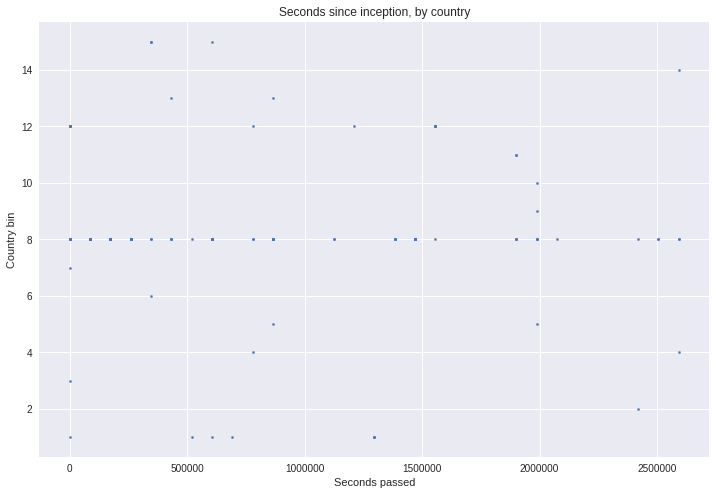

In [11]:
import datetime
n_countries = len(uniq_countries)

country_bins = {}
bin_countries = {}
min_date = datetime.datetime.strptime(df["date"].min(), "%Y-%m-%d")
datetimes = df["date"].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d") - min_date))

y_labels = uniq_countries+['']

print("Country bins: ")
cbin_ls = []
for i, country in enumerate(y_labels):
    country_bins[country] = i+1
    cbin_ls.append(''.join([country, ': ', str(i+1)]))
print(*cbin_ls, sep='\n')
plt.figure(figsize=(12, 8))
date_country_bins = df["country"].apply(lambda x: float(country_bins[x]))
plt.scatter(datetimes.apply(lambda x: x.total_seconds()), date_country_bins, 5)

plt.title("Seconds since inception, by country")
plt.xlabel("Seconds passed")
plt.ylabel("Country bin")
plt.show()

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**From this time plot, we get a sense of stories' spread in different countries. A next step from here could be to color these markers by title name. This, to me, seems like a more effective plotting than clustering by title, since we know that the titles are the same (haven't checked to see this is 100% true).**
</div>
</div>

In [12]:
# ref: http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib#22408462
# need to find matplotlib.colors equivalent
cnames = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32' }
print(len(cnames))

140


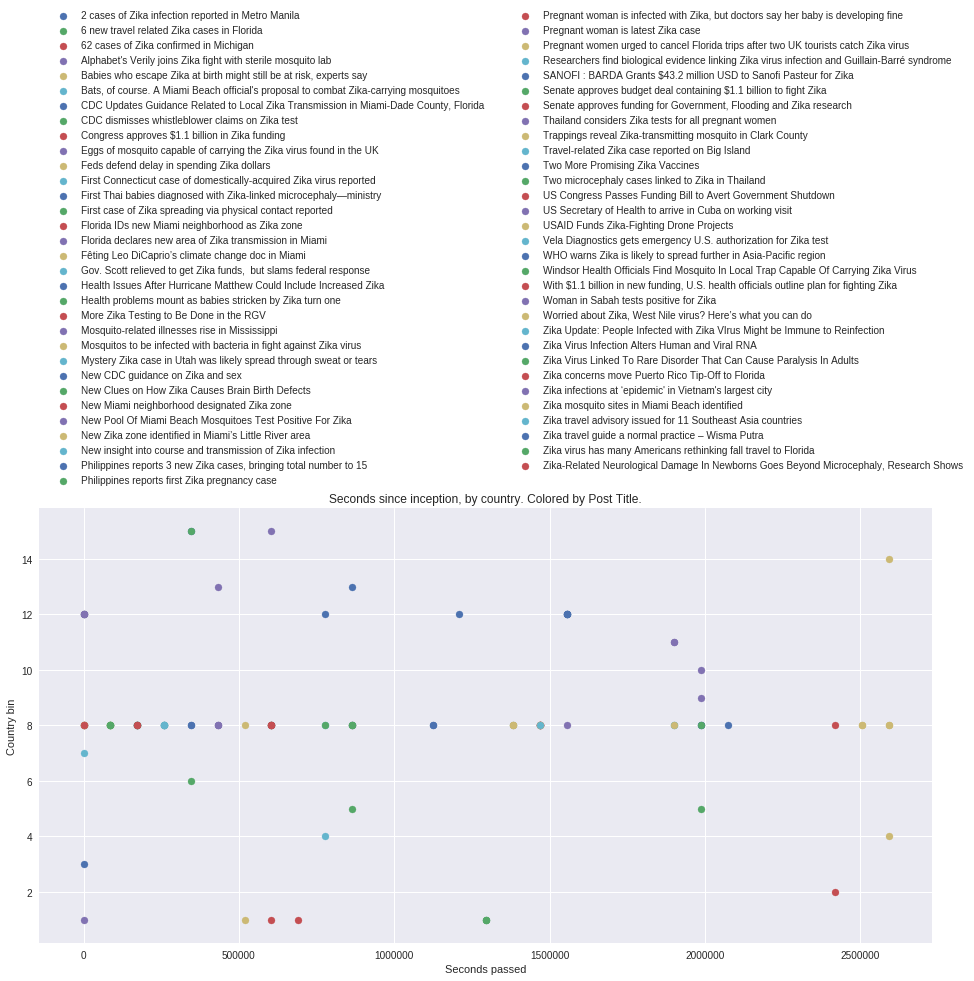

Country bins: 
Brasil: 1
Guatemala: 2
France: 3
Colombia: 4
Canada: 5
China: 6
Deutschland: 7
United States of America: 8
UK: 9
Cuba: 10
Việt Nam: 11
Philippines: 12
Malaysia: 13
Australia: 14
Thailand: 15
: 16


In [14]:
import random
title_groupby = df.groupby(["title"])
n_titles = len(title_groupby)

plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
# create random color palette for title groups
# ref: http://stackoverflow.com/questions/6482889/get-random-sample-from-list-while-maintaining-ordering-of-items#6482922
plot_cnames = [ cnames[i] for i in sorted(random.sample(cnames.keys(), n_titles)) ]
plot_groups = []
title_groups = []
for i, (name, group) in enumerate(title_groupby):
    g_datetimes = group["date"].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d") - min_date))
    g_date_country_bins = group["country"].apply(lambda x: float(country_bins[x]))
    title_groups.append(name)
    plot_groups.append(ax.scatter(g_datetimes.apply(lambda x: x.total_seconds()), g_date_country_bins))

ax.legend(plot_groups,
           title_groups,
           scatterpoints=1,
           bbox_to_anchor=(0., 1.02, 1.05, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=1.)
    
ax.set_title("Seconds since inception, by country. Colored by Post Title.")
ax.set_xlabel("Seconds passed")
ax.set_ylabel("Country bin")
plt.show()
print("Country bins: ", *cbin_ls, sep='\n')

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**This colored scatterplot shows the titles by country over time. Though the colors could be picked to better maximize the distances between each color class, this plot gives a sense of the spread of stories within-country and across countries.**
</div>
</div>

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<div class="alert alert-info" role="alert" style="margin: 10px">
**As shown above, clustering by ngrams is not a bad idea given that there are redundant titles at different coordinates. Another idea is to cluster on store names if that assumption holds true to all geolocation resolutions. Both of these clustering approaches would give information as to the distribution of a story, yet each has limits. I prefer direct grouping as I did in the time scatter plot above. That said, we may not be able to assume that the titles are always exactly the same, which clustering would be more robust during. Additionally, some of these posts seem to be on the same topic. This would be even more reason to use n-grams in creating clusters. <br/> <br/> 

Besides different clustering methods, somethings to look into are word frequencies and adding in more data. I noticed a few post titles containing mosquito. Perhaps some inference can be made concerning causes of spread.  <br/> <br/>

Towards the end of the notebook, I found http://www.telegraph.co.uk/news/2016/03/22/zika-outbreak-where-is-the-virus-spreading/, which supports the argument of a sampling bias for the dataset. Though this dataset was organized very well and doesn't have any instances with key missing data, other areas of information will have to be investigated. Here (https://knoema.com/atlas/topics/Zika/datasets), may be one instance of a place to get more data from.**
</div>
</div>

In [21]:
from nltk import ngrams

n = 3
k = 27
ngrams = df["title"].apply(lambda x: ngrams(x.split(), n))
for grams in ngrams:
    print(*grams)
    
vectorizer = TfidfVectorizer(min_df = 0, max_df=0.5, 
                             stop_words = "english", charset_error = "ignore", ngram_range = (1,n))
vec=vectorizer.fit(ngrams)   # train vec using list1
vectorized = vec.transform(ngrams)   # transform list1 using vec
km=KMeans(n_clusters=k, init='k-means++', n_init=10, 
          max_iter=1000, tol=0.0001, precompute_distances=True, verbose=0, random_state=None, cpy_x=True, n_jobs=1)
km.fit(vectorized)

cluster_pred = km.predict(vectorized) # classify into three clusters
cluster_centers = km.cluster_centers_
print(cluster_centers)    
    
clusters = {}
for i in range(0, k):
    clusters[i] = []
    for x,y in zip(cluster_pred, vectorized):
        if x == i:
            clusters[i].append(y)

('Fêting', 'Leo', 'DiCaprio’s') ('Leo', 'DiCaprio’s', 'climate') ('DiCaprio’s', 'climate', 'change') ('climate', 'change', 'doc') ('change', 'doc', 'in') ('doc', 'in', 'Miami')
('With', '$1.1', 'billion') ('$1.1', 'billion', 'in') ('billion', 'in', 'new') ('in', 'new', 'funding,') ('new', 'funding,', 'U.S.') ('funding,', 'U.S.', 'health') ('U.S.', 'health', 'officials') ('health', 'officials', 'outline') ('officials', 'outline', 'plan') ('outline', 'plan', 'for') ('plan', 'for', 'fighting') ('for', 'fighting', 'Zika')
('Congress', 'approves', '$1.1') ('approves', '$1.1', 'billion') ('$1.1', 'billion', 'in') ('billion', 'in', 'Zika') ('in', 'Zika', 'funding')
('Bats,', 'of', 'course.') ('of', 'course.', 'A') ('course.', 'A', 'Miami') ('A', 'Miami', 'Beach') ('Miami', 'Beach', "official's") ('Beach', "official's", 'proposal') ("official's", 'proposal', 'to') ('proposal', 'to', 'combat') ('to', 'combat', 'Zika-carrying') ('combat', 'Zika-carrying', 'mosquitoes')
('Zika', 'mosquito', 'site

NameError: name 'TfidfVectorizer' is not defined